# Wave propagation (hyperbolic PDE)

## libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from scipy import fft, ifft

## initialization

In [2]:
n = 2

COURANT = 0.2
LENGTH = 10
X_max = LENGTH / 2
X_min = - X_max
T_min = 0

NUMBER_X = 100
NUMBER_T = 700

T_max =  COURANT * (X_max - X_min) * NUMBER_T / NUMBER_X + T_min

In [3]:
def create_arrays(NUMBER_X, NUMBER_T):
    X_RANGE = np.linspace(X_min, X_max, NUMBER_X + 1)
    T_RANGE = np.linspace(T_min, T_max, NUMBER_T + 1)
    K_RANGE = np.linspace(- NUMBER_X * np.pi / LENGTH, NUMBER_X * np.pi / LENGTH, NUMBER_X + 1)

    X_STEP = X_RANGE[1] - X_RANGE[0]
    T_STEP = T_RANGE[1] - T_RANGE[0]

    X_RANGE = X_RANGE[:-1]
    K_RANGE = K_RANGE[:-1]

    X, T = np.meshgrid(X_RANGE, T_RANGE, indexing='ij')
    return X, T, K_RANGE

def animation_plot(E, E_exact, T, kind='re'):
    T_STEP = T[0, 1] - T[0, 0]
    if kind == 're':
        E = np.real(E)
        E_exact = np.real(E_exact)
    elif kind == 'im':
        E = np.imag(E)
        E_exact = np.imag(E_exact)
    elif kind == 'abs':
        E = np.absolute(E)
        E_exact = np.absolute(E_exact)
    else:
        raise ValueError('Wrong kind value')
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.axis([X_min, X_max, E.min(), E.max()])

    l1, = ax.plot(X[:,0], E[:, 10], lw=3, color='black')
    l2, = ax.plot(X[:,0], E_exact[:, 10], lw=2, color='red')
    
    ax.grid(c='#aaaaaa', ls='--')

    ax.set_ylabel("f(x)")
    ax.set_xlabel("x")

    def animate(i):
        l1.set_data(X[:,0], E[:, i])
        l2.set_data(X[:,0], E_exact[:, i])
        l1.set_label('t = ' + '%.3f' % (i * T_STEP))

        legend = plt.legend(loc='upper right')
        return l1, l2, legend

    ani = animation.FuncAnimation(fig, animate, frames= np.arange(0, NUMBER_X, 5), interval=60)

    #ani.save("solution.mp4")
    return HTML(ani.to_jshtml())

def hermite(n, x):
    if n == 0:
        return 1
    if n == 1:
        return 2 * x
    if n == 2:
        return 4 * x ** 2 - 2
    if n == 3:
        return 8 * x ** 3 - 12 * x
    if n == 4:
        return 16 * x ** 4 - 48 * x ** 2 + 12

def potential(X):
    return X ** 2 / 2

def exact_solution(X, T, n, kind=None):
    psi = np.zeros_like(X, dtype=complex)
    
    if kind == 'coherent':
        p, q = 0, 0
        z = (q + 1j * p) / np.sqrt(2)
        summa = 0
        for i in range(5):
            summa += z ** i * exact_solution(X, T, i) / np.sqrt(np.math.factorial(i))
        psi = summa * np.exp(- np.absolute(z) ** 2 / 2)
        
        return psi
    
    psi = (np.exp(- 1j * (n + 1/2) * T) * 
           (np.math.factorial(n) * (2 ** n) * np.sqrt(np.pi)) ** -0.5 *
           np.exp(- potential(X)) *
           hermite(n, X))
    
    return psi

def fragmentation_method(X, T, K, initial):
    
    psi = np.zeros_like(X, dtype=complex)
    psi[:, 0] = initial
    T_STEP = T[0, 1] - T[0, 0]
    
    for i in range(len(T[0, :]) - 1):
        u = np.exp(-1j * potential(X[:, 0]) * T_STEP / 2) * psi[:, i]
        ind = np.arange(1, len(u), 2, dtype=int)
        u[ind] *= (-1)
        u = fft(u)
        u *= np.exp(-1j * T_STEP * K ** 2 / 2)
        u = ifft(u)
        u[ind] *= (-1)
        u = np.exp(-1j * potential(X[:, 0]) * T_STEP / 2) * u
        psi[:, i+1] = u

    return psi

def get_initial_state(X, n, kind=None):
    if kind == 'coherent':
        p, q = 0, 0
        z = (q + 1j * p) / np.sqrt(2)
        summa = 0
        for i in range(5):
            summa += z ** i * get_initial_state(X, i) / np.sqrt(np.math.factorial(i))
        initial = summa * np.exp(- np.absolute(z) ** 2/ 2)
        
        return initial
        
    initial = ((np.math.factorial(n) * 2 ** n * np.sqrt(np.pi)) ** -0.5 *
                np.exp(- potential(X[:, 0])) *
                hermite(n, X[:, 0]))
    
    return initial

## initial state

In [4]:
X, T, K_RANGE = create_arrays(NUMBER_X, NUMBER_T)
initial = get_initial_state(X, n)

## main procedure

In [5]:
psi = fragmentation_method(X, T, K_RANGE, initial)
psi_exact = exact_solution(X, T, n)

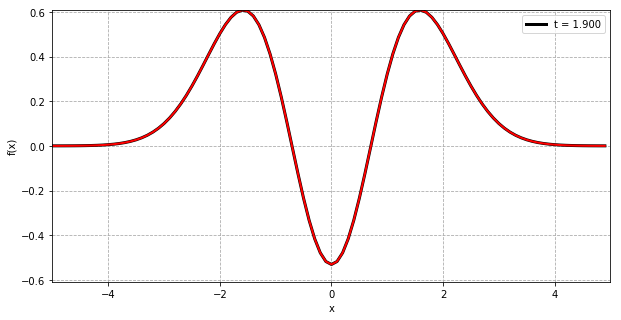

In [6]:
animation_plot(psi, psi_exact, T, 'im')

## accuracy

In [7]:
psi_result = np.repeat(np.zeros_like(X, dtype=complex)[np.newaxis, :, :], 3, axis=0)
for h in [1,2,4]:
    number_x = NUMBER_X * h
    number_t = NUMBER_T * h
    X_, T_, K_RANGE = create_arrays(number_x, number_t)
    initial = get_initial_state(X_, n)
    psi = fragmentation_method(X_, T_, K_RANGE, initial)
    psi_result[int(np.log2(h)), :, :] = psi[::h, ::h]

In [8]:
L = ((np.abs(psi_result[0][1:, 1:] - psi_result[1][1:, 1:]).max(axis=0)) 
     / (np.abs(psi_result[2][1:, 1:] - psi_result[1][1:, 1:])).max(axis=0))

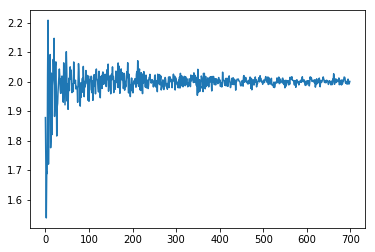

In [9]:
plt.plot(np.log2(L))

In [10]:
L = ((np.abs(psi_result[0][1:, 1:] - psi_result[1][1:, 1:]).max(axis=1)) 
     / (np.abs(psi_result[2][1:, 1:] - psi_result[1][1:, 1:])).max(axis=1))

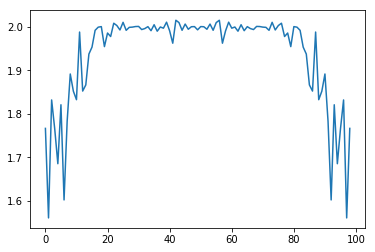

In [11]:
plt.plot(np.log2(L))